In [1]:
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# read in expr_preprocessed.h5ad
expr = sc.read_h5ad('expr_preprocessed.h5ad')
expr.uns["log1p"]["base"] = None
expanding_barcodes = pd.read_csv("barcodes_expanding_vs_contracting.csv", index_col=0)
barcodes_w_sc_and_tcr = set(expanding_barcodes.index) & set(expr.obs.index)

In [3]:
# Filter barcodes to only include those with shared data
expanding_barcodes = expanding_barcodes.loc[list(barcodes_w_sc_and_tcr)]

# Label sc data to clarify which have tcr data
expr.obs["has_tcr_data"] = False
expr.obs.loc[list(barcodes_w_sc_and_tcr), "has_tcr_data"] = True

In [4]:
expr = expr[expr.obs["has_tcr_data"]]

In [89]:
barcode_clones = pd.read_csv("barcode_clonotypes.csv")
barcode_to_clone_id = barcode_clones.set_index("barcode")["clone_id"].to_dict()
expr.obs["clone_id"] = [barcode_to_clone_id[barcode] for barcode in expr.obs.index]

## Check whether the expanding early clones are more likely to highly express the 'highly variable' genes

In [44]:
high_var_genes = expr.var.query("highly_variable")
expr_df = pd.DataFrame(expr.X, index=expr.obs.index, columns=expr.var.index)

def make_violin_plots_for_timepoint(timepoint: str = "early"):

   barcodes_that_expand = expanding_barcodes.query(f"{timepoint} == True").index
   barcodes_that_contract = expanding_barcodes.query(f"{timepoint} == False").index

   high_var_non_trb = high_var_genes.sort_values("dispersions_norm", ascending=False).query("trb == False").head(5).index.tolist()
   high_var_trb = high_var_genes.sort_values("dispersions_norm", ascending=False).query("trb == True").head(5).index.tolist() 
   random_5_genes = expr.var.sample(5).index.tolist()
      
   for title, genes_to_plot in zip(["High var non-TRB genes", "High var TRB genes", "Randomly selected genes"], [high_var_non_trb, high_var_trb, random_5_genes]):
      high_var_trb_expr = expr_df.loc[list(barcodes_that_expand)+list(barcodes_that_contract), genes_to_plot]

      high_var_trb_expr = high_var_trb_expr.reset_index().melt(id_vars="index").rename({"index": "barcode", "variable": "gene", "value": "expr_level"}, axis=1)

      high_var_trb_expr = high_var_trb_expr.set_index("barcode")
      high_var_trb_expr.loc[barcodes_that_expand, "kinetics"] = "expand"
      high_var_trb_expr.loc[barcodes_that_contract, "kinetics"] = "contract"

      plt.figure(figsize=(10, 5))
      sns.violinplot(data=high_var_trb_expr, x="gene", y="expr_level", hue="kinetics", split=True, linewidth=0.25)
      sns.stripplot(data=high_var_trb_expr, x="gene", y="expr_level", hue="kinetics", zorder=1, s=1.5, alpha=0.25)

      # fix legend so it only shows each state once
      handles, labels = plt.gca().get_legend_handles_labels()
      by_label = dict(zip(labels, handles))
      plt.legend(by_label.values(), by_label.keys(), title=f"{timepoint} kinetics", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

      plt.title(f"Expression of high variance genes in {timepoint} expanding and contracting clones, {title}")

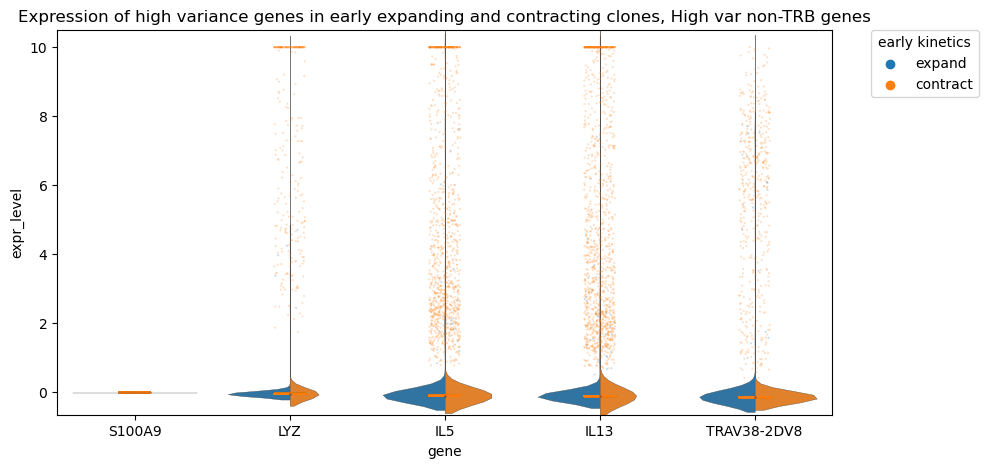

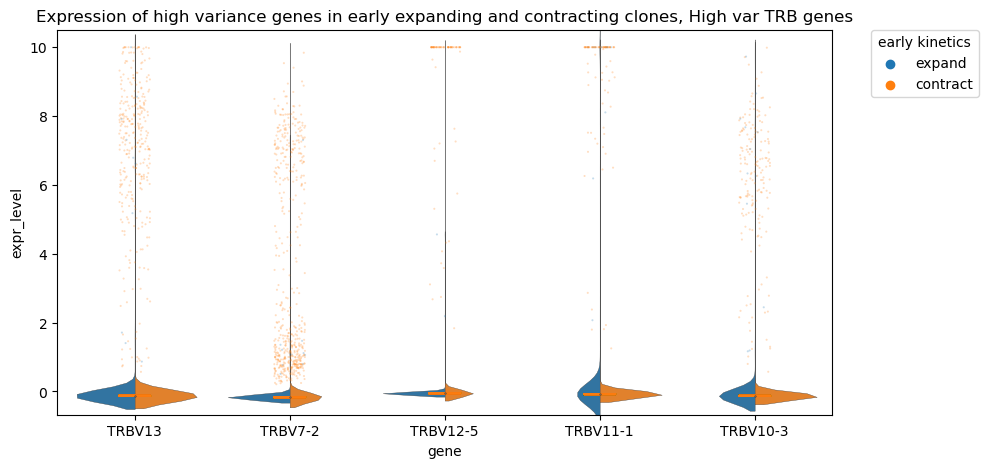

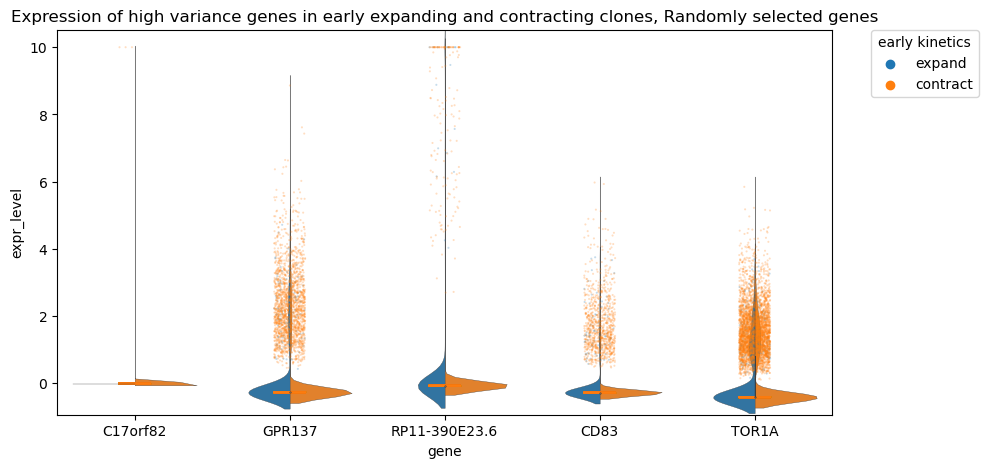

In [45]:
make_violin_plots_for_timepoint("early")

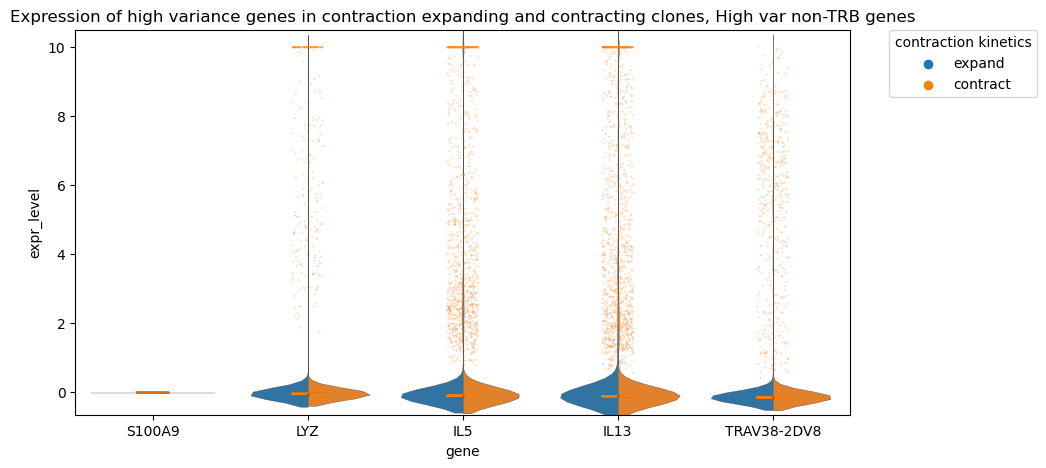

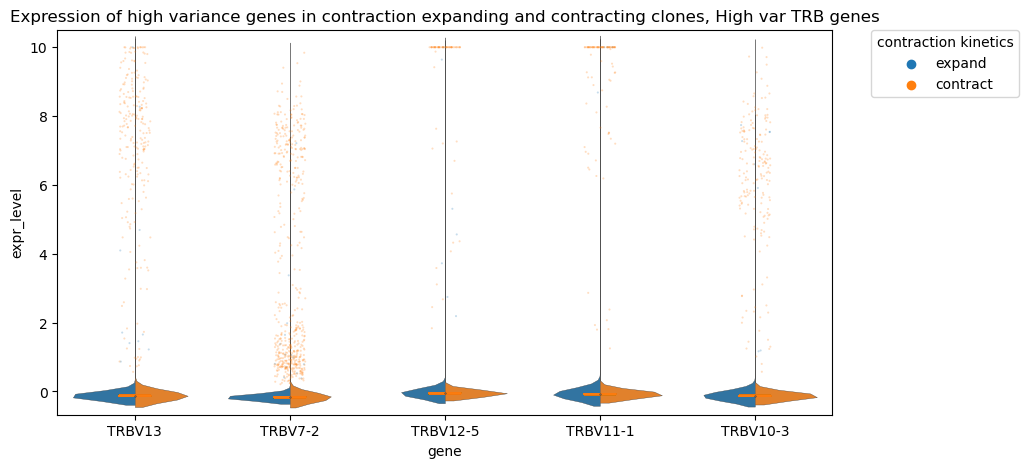

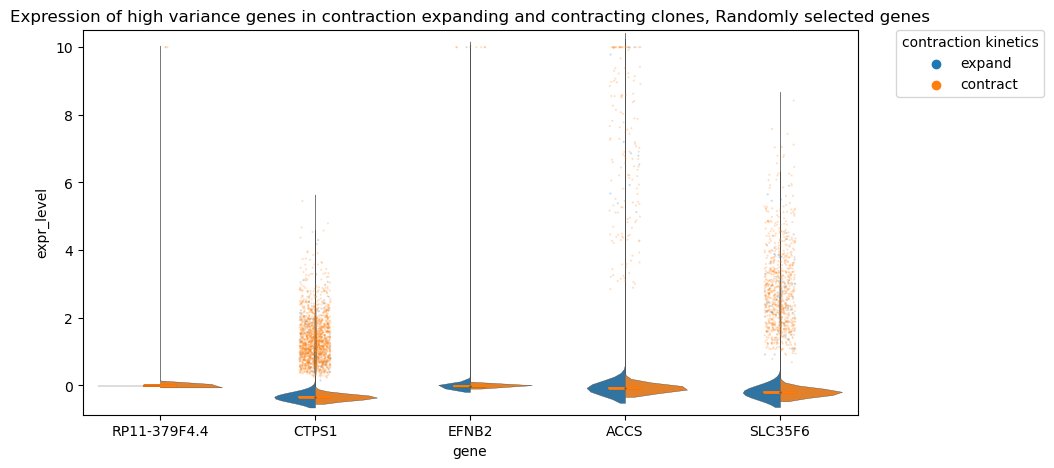

In [7]:
make_violin_plots_for_timepoint("contraction")

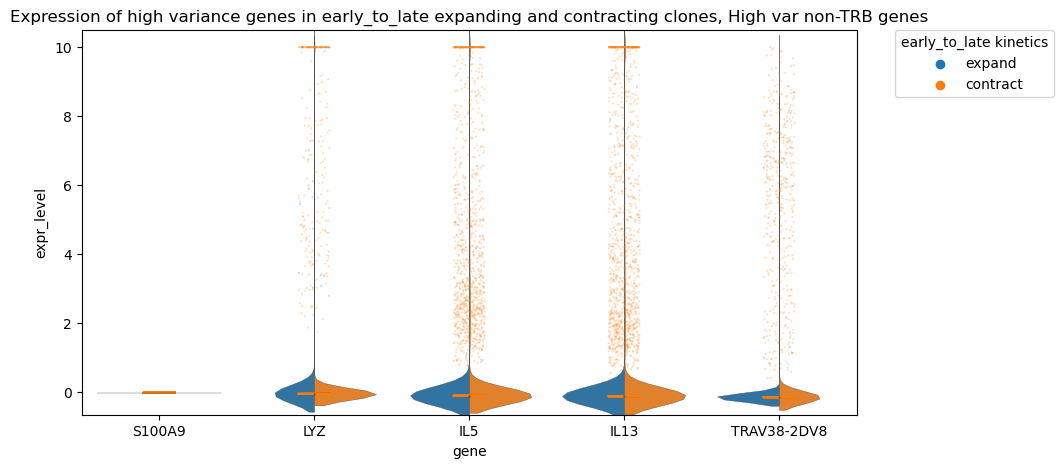

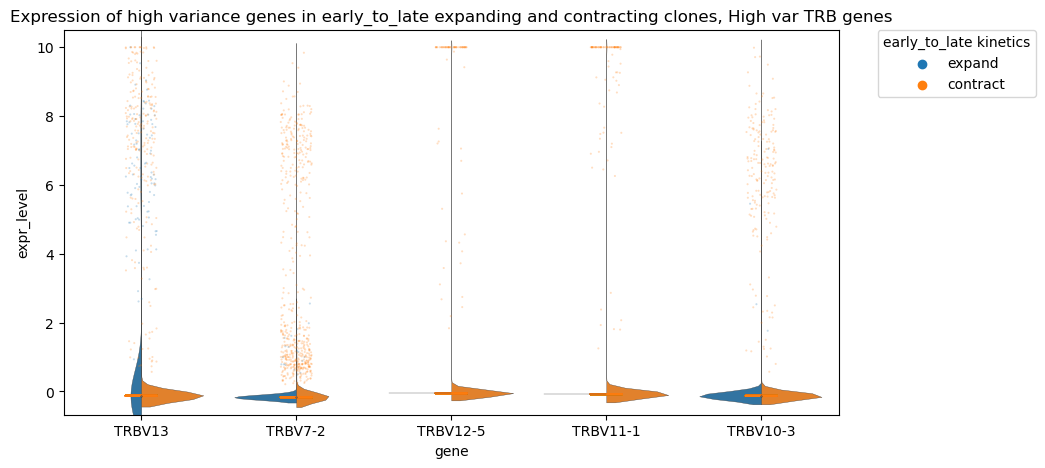

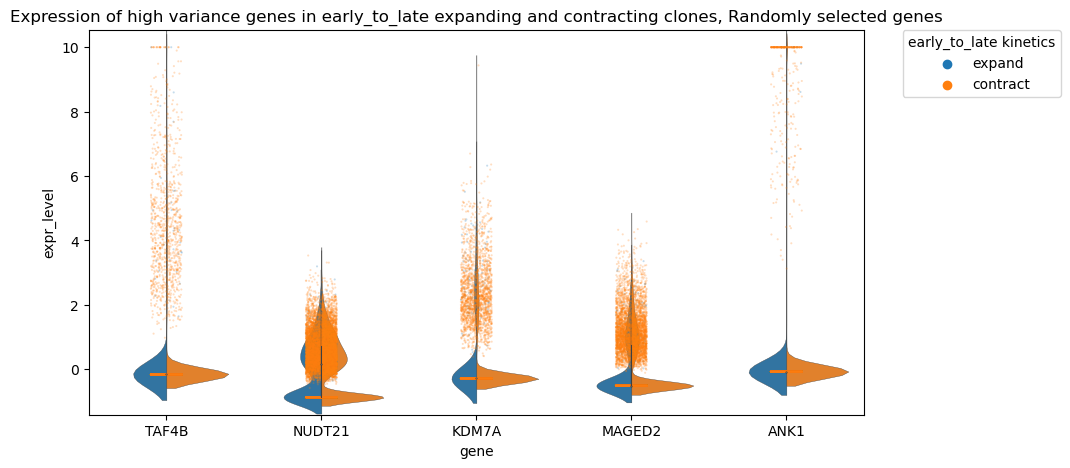

In [8]:
make_violin_plots_for_timepoint("early_to_late")

#### As a sanity check, look more closely into the expression of S100A9, which is a gene that is highly expressed but has very little expression

In [9]:
expr.var.loc["S100A9"]

mt                           False
n_cells_by_counts               77
mean_counts               0.019689
pct_dropout_by_counts     99.87614
total_counts                1224.0
n_cells                         77
highly_variable               True
means                     0.013921
dispersions               4.757143
dispersions_norm         14.140092
trb                          False
mean                       0.00145
std                       0.058021
Name: S100A9, dtype: object

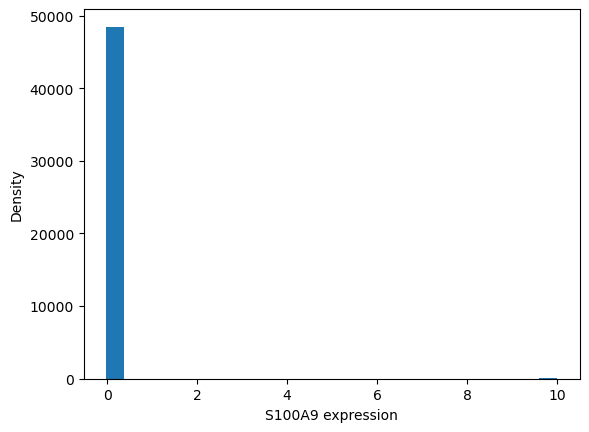

In [10]:
plt.hist(expr_df["S100A9"], bins=25)
plt.xlabel("S100A9 expression")
plt.ylabel("Density")
plt.show()

# it seems like it was only expressed in a very small population of cells (77) and ust happens to have pretty high dispersion because of the few cells that had high expression

## Plot differential expression across timepoints of clones that expand vs contract

In [11]:
meta = pd.read_csv("geo_metadata.csv")

id_to_timepoint_type = dict(zip(meta["id_in_expmatrix"].astype(str), meta["time_point_type"]))
id_to_disease_state = dict(zip(meta["id_in_expmatrix"].astype(str), meta["disease_state"]))
id_to_patient_id = dict(zip(meta["id_in_expmatrix"].astype(str), meta["patient_id"]))

expr.obs["sample_id"] = [barcode.split("-")[-1] for barcode in expr.obs.index]
expr.obs["disease_state"] = expr.obs["sample_id"].map(id_to_disease_state)
expr.obs["time_point_type"] = expr.obs["sample_id"].map(id_to_timepoint_type)
expr.obs["patient_id"] = expr.obs["sample_id"].map(id_to_patient_id)

/var/folders/pf/xdq1hzpd1sg02zxbtb77nhm80000gn/T/ipykernel_35907/1193207089.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  expr.obs["sample_id"] = [barcode.split("-")[-1] for barcode in expr.obs.index]


In [56]:
# Read in file with barcode kinetics
barcode_kinetics = pd.read_csv("barcode_kinetics.csv", index_col=0)
barcodes_w_sc_and_tcr = set(barcode_kinetics.index) & set(expr.obs.index)
barcode_kinetics = barcode_kinetics.loc[list(barcodes_w_sc_and_tcr)]



In [67]:
def plot_deg_for_subset(kinetics_series: pd.Series, expr_df: pd.DataFrame):
    # Only include expression info for barcodes that have kinetics data
    expr_df = expr_df[expr_df.obs.index.isin(kinetics_series.index)]

    # is this next line necessary?
    kinetics_series = kinetics_series.loc[expr_df.obs.index]
    expr_df.obs = expr_df.obs.assign(kinetics=kinetics_series, dtype="category")

    sc.tl.rank_genes_groups(expr_df, groupby="kinetics", method="wilcoxon", n_genes=1000)
    sc.pl.rank_genes_groups(expr_df, n_genes=25, sharey=False)
    sc.pl.rank_genes_groups_heatmap(expr_df, n_genes = 25, key="rank_genes_groups", groupby="kinetics", show_gene_labels=True, standard_scale="var")

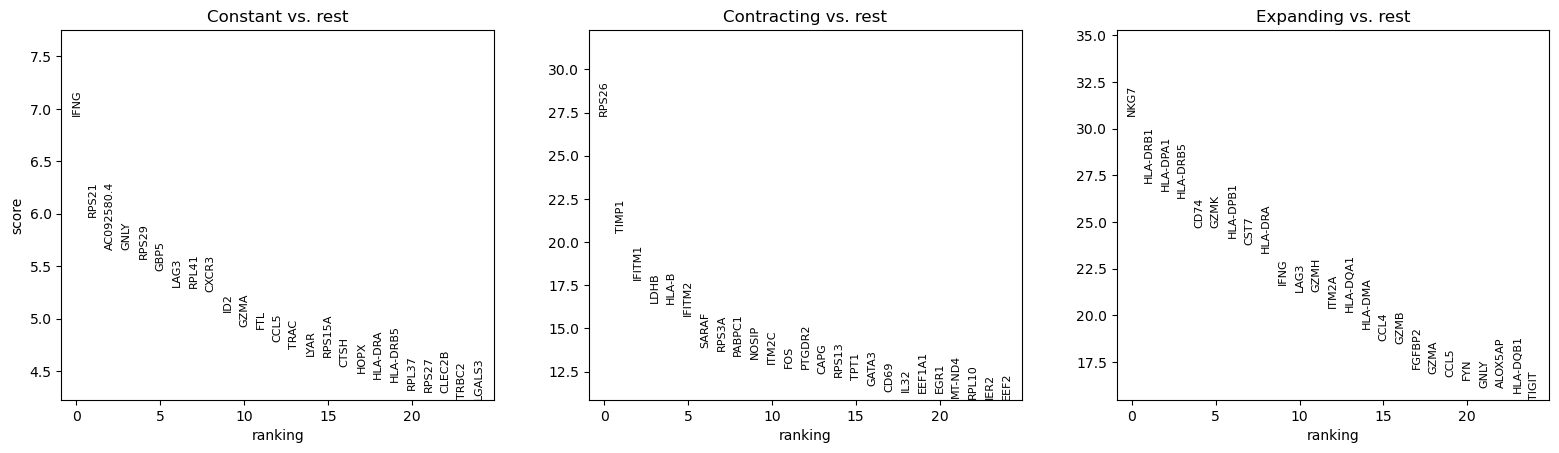

         Falling back to preprocessing with `sc.pp.pca` and default params.


/Users/elanasimon/miniconda3/envs/bmi/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


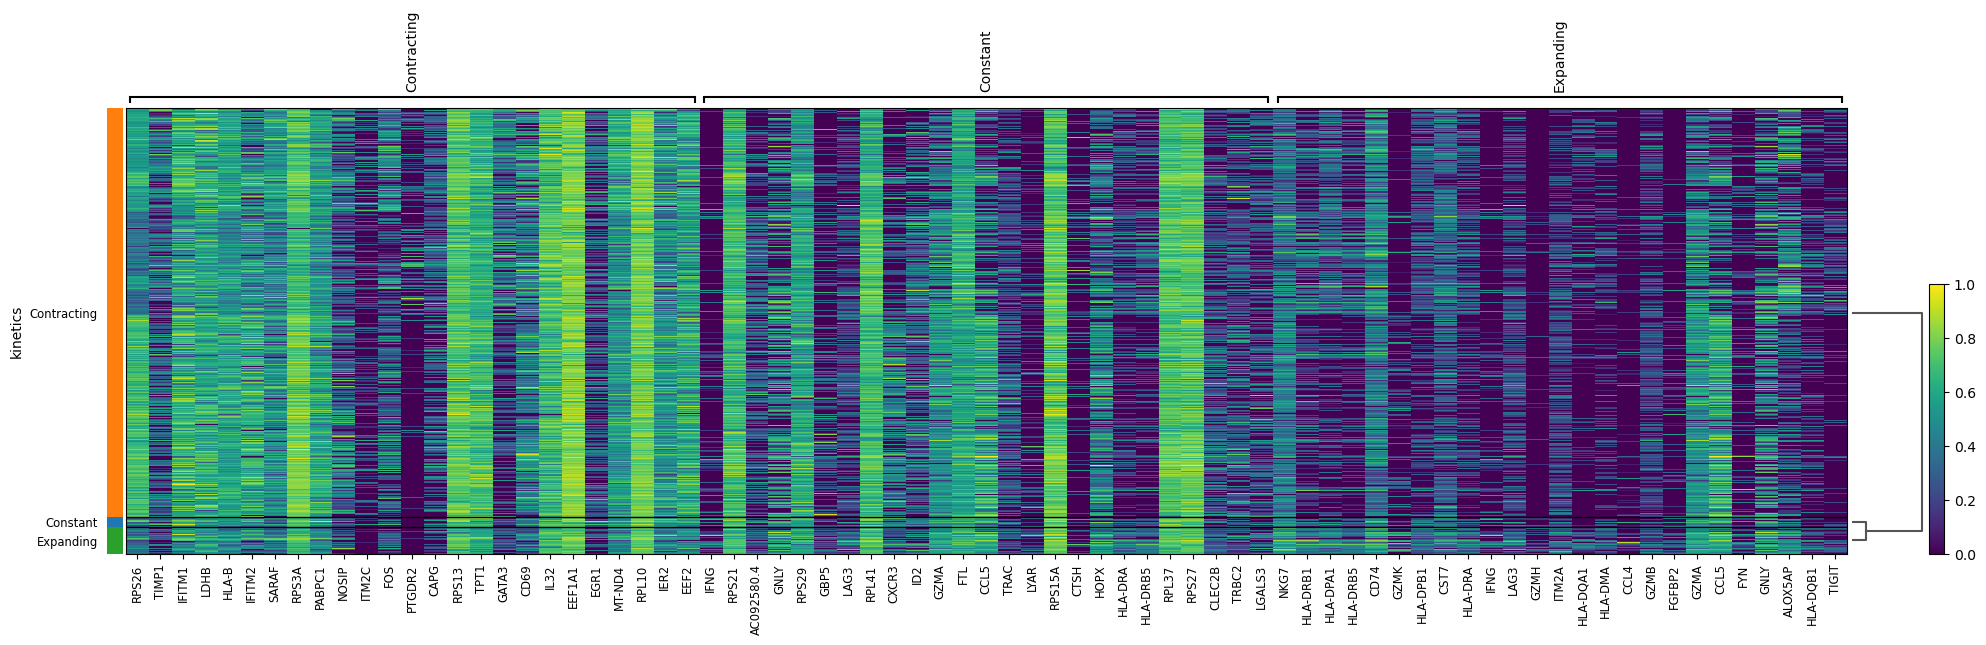

In [68]:
# Plotting the expression values at IP time point, split based on their kinetic values going to early time point
plot_deg_for_subset(barcode_kinetics["early"], expr[expr.obs["time_point_type"]=="IP"].copy())

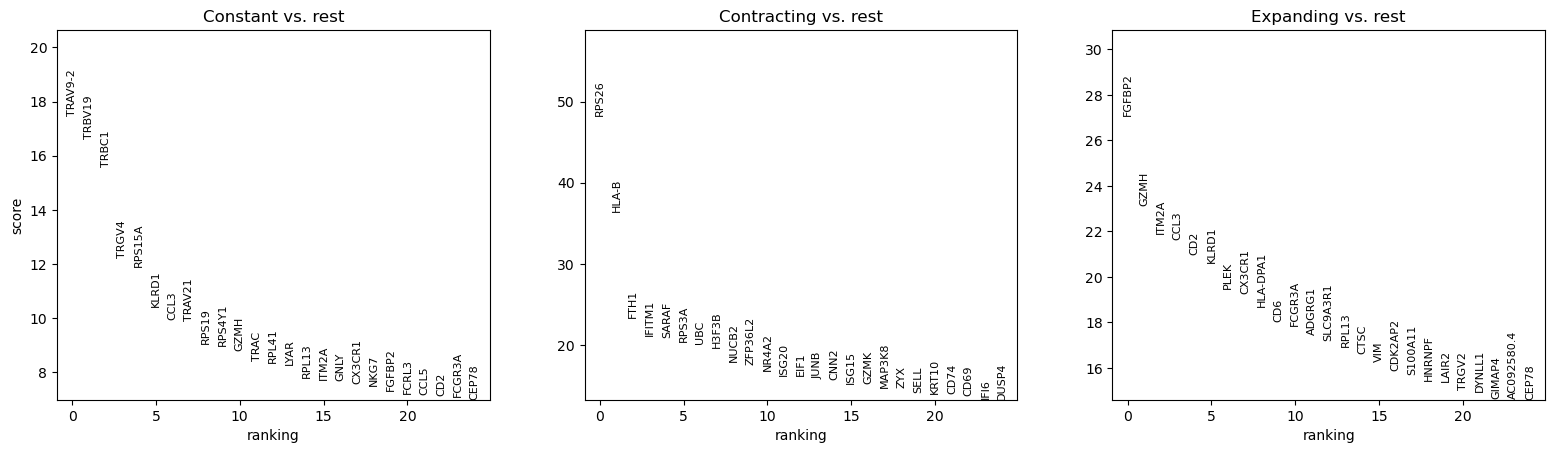

         Falling back to preprocessing with `sc.pp.pca` and default params.


/Users/elanasimon/miniconda3/envs/bmi/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


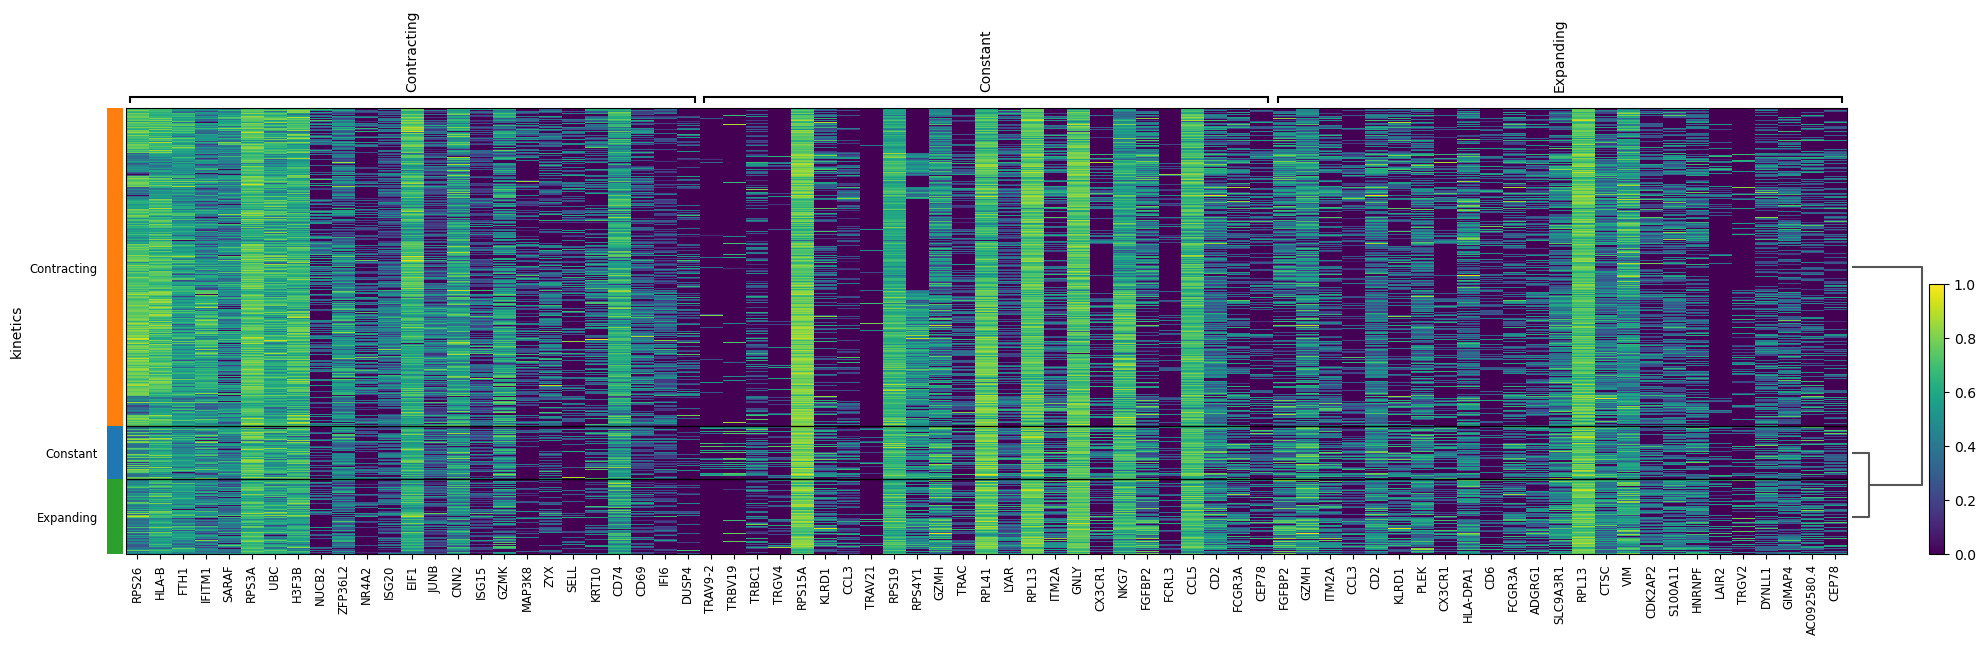

In [70]:
# Plotting the expression values at Contraction time point, split based on their kinetic values going to late time point
plot_deg_for_subset(barcode_kinetics["contraction"], expr[expr.obs["time_point_type"]=="Early"].copy())

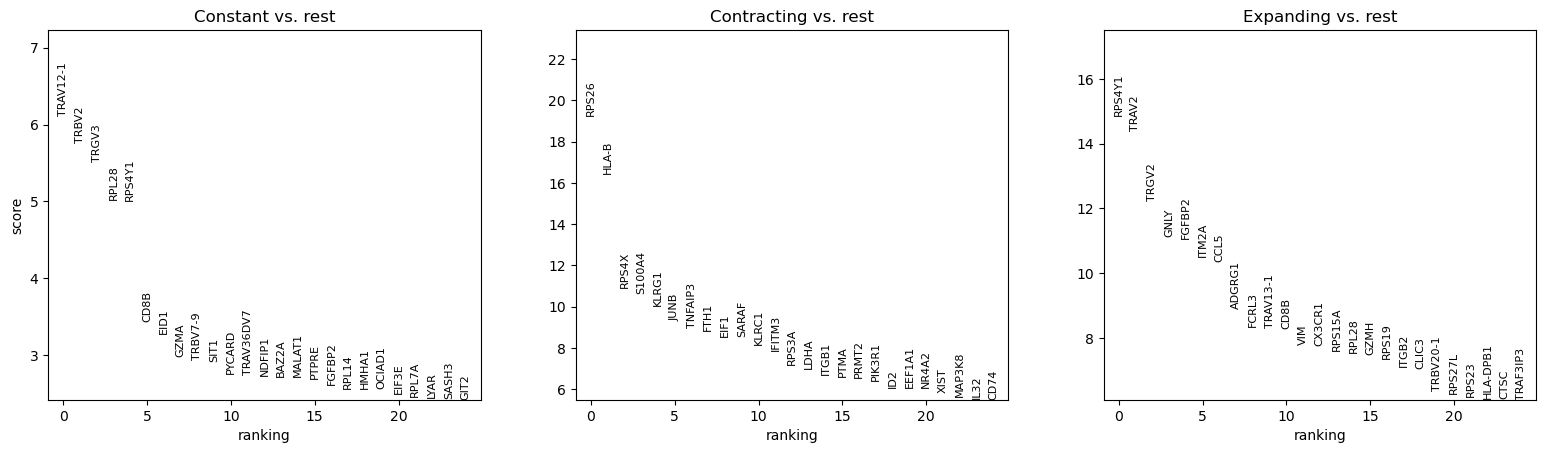

         Falling back to preprocessing with `sc.pp.pca` and default params.


/Users/elanasimon/miniconda3/envs/bmi/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


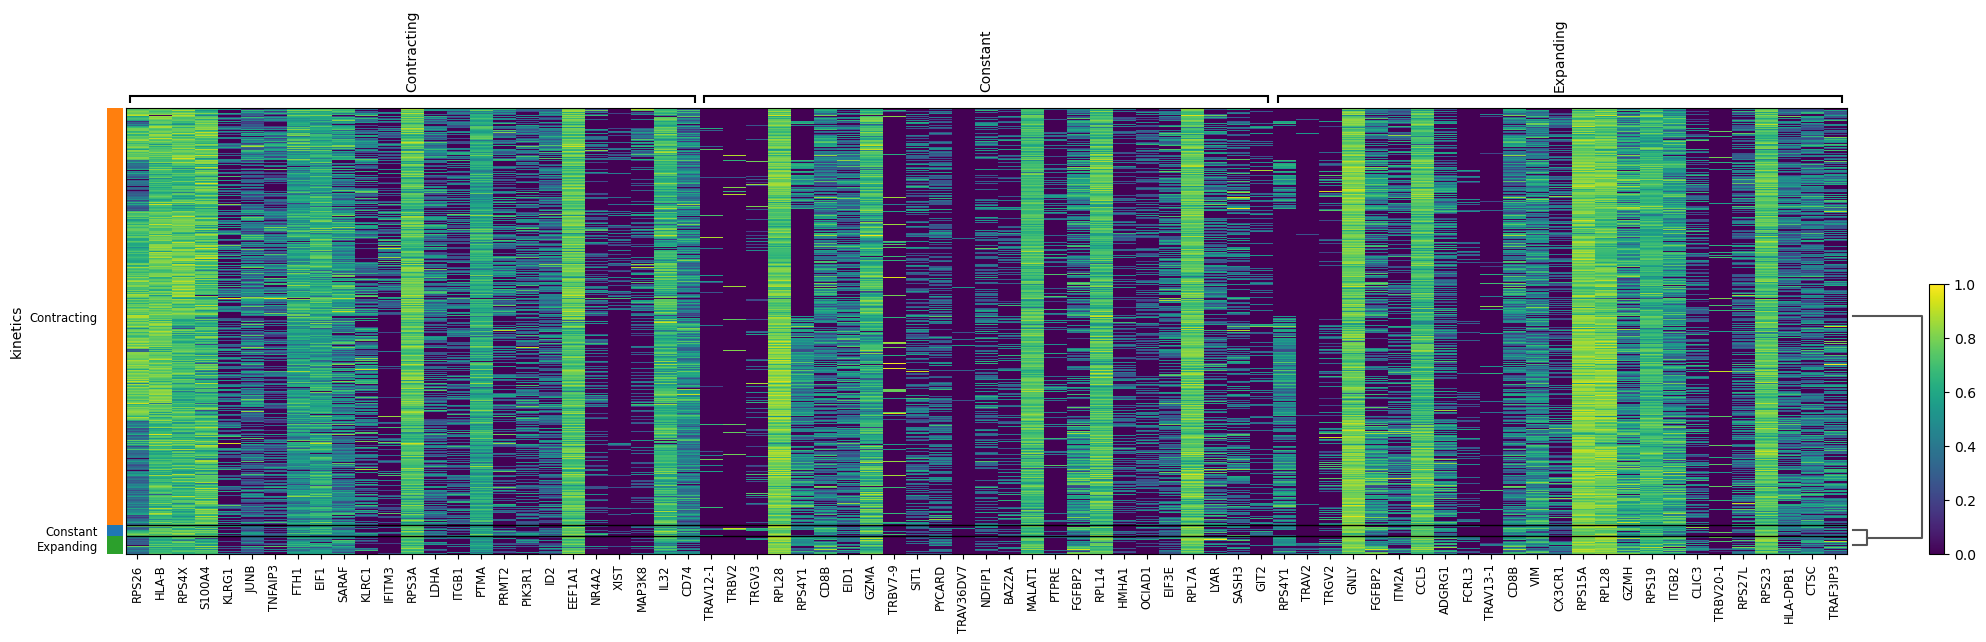

In [69]:
# Plotting the expression values at Contraction time point, split based on their kinetic values going to late time point
plot_deg_for_subset(barcode_kinetics["late"], expr[expr.obs["time_point_type"]=="Contraction"].copy())

## Plot just top gene expr _per patient_

In [74]:
expr.obs.groupby("patient_id").get_group("CLL-1").index

Index(['AAACCTGAGCGTCTAT-1', 'AAACCTGCAATAGAGT-1', 'AAACCTGCATGACGGA-1',
       'AAACCTGGTAGTGAAT-1', 'AAACCTGGTCTCCCTA-1', 'AAACCTGTCCCACTTG-1',
       'AAACGGGCACGTAAGG-1', 'AAACGGGGTCCTCCAT-1', 'AAACGGGGTGAGGCTA-1',
       'AAACGGGGTGCAACTT-1',
       ...
       'TTTACTGTCCATGCTC-4', 'TTTATGCGTCAAACTC-4', 'TTTATGCTCGAATGGG-4',
       'TTTATGCTCGGCTTGG-4', 'TTTGCGCAGGACGAAA-4', 'TTTGCGCCATGAGCGA-4',
       'TTTGCGCGTGATGATA-4', 'TTTGCGCGTGTTGGGA-4', 'TTTGCGCGTTTGACTG-4',
       'TTTGTCAAGCAGGCTA-4'],
      dtype='object', length=14265)

CLL-1


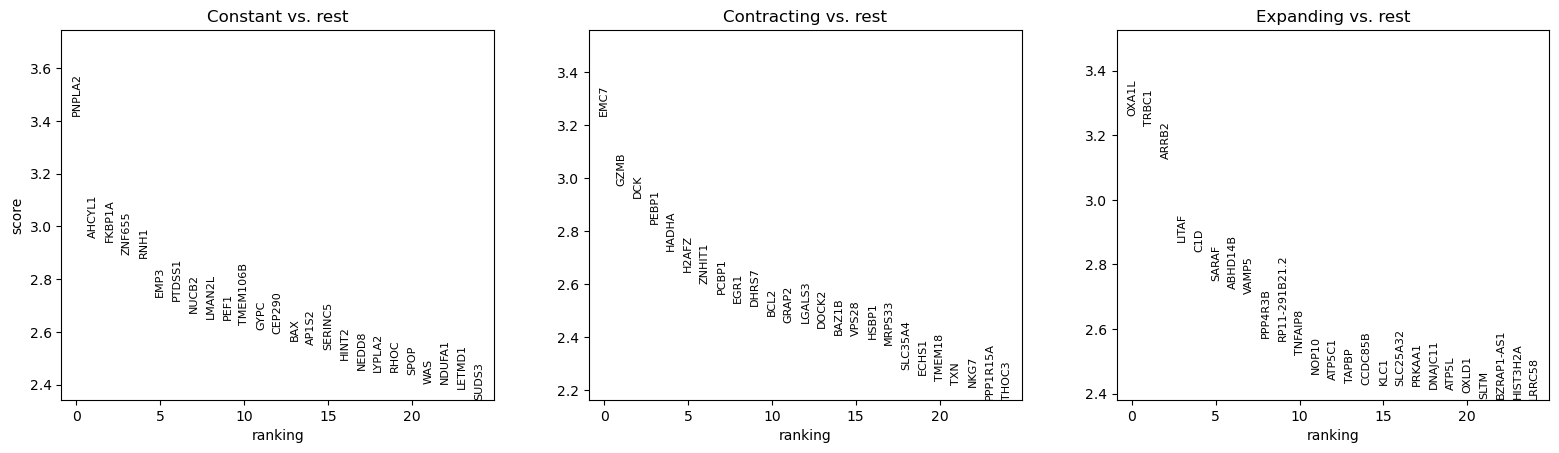

         Falling back to preprocessing with `sc.pp.pca` and default params.


/Users/elanasimon/miniconda3/envs/bmi/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


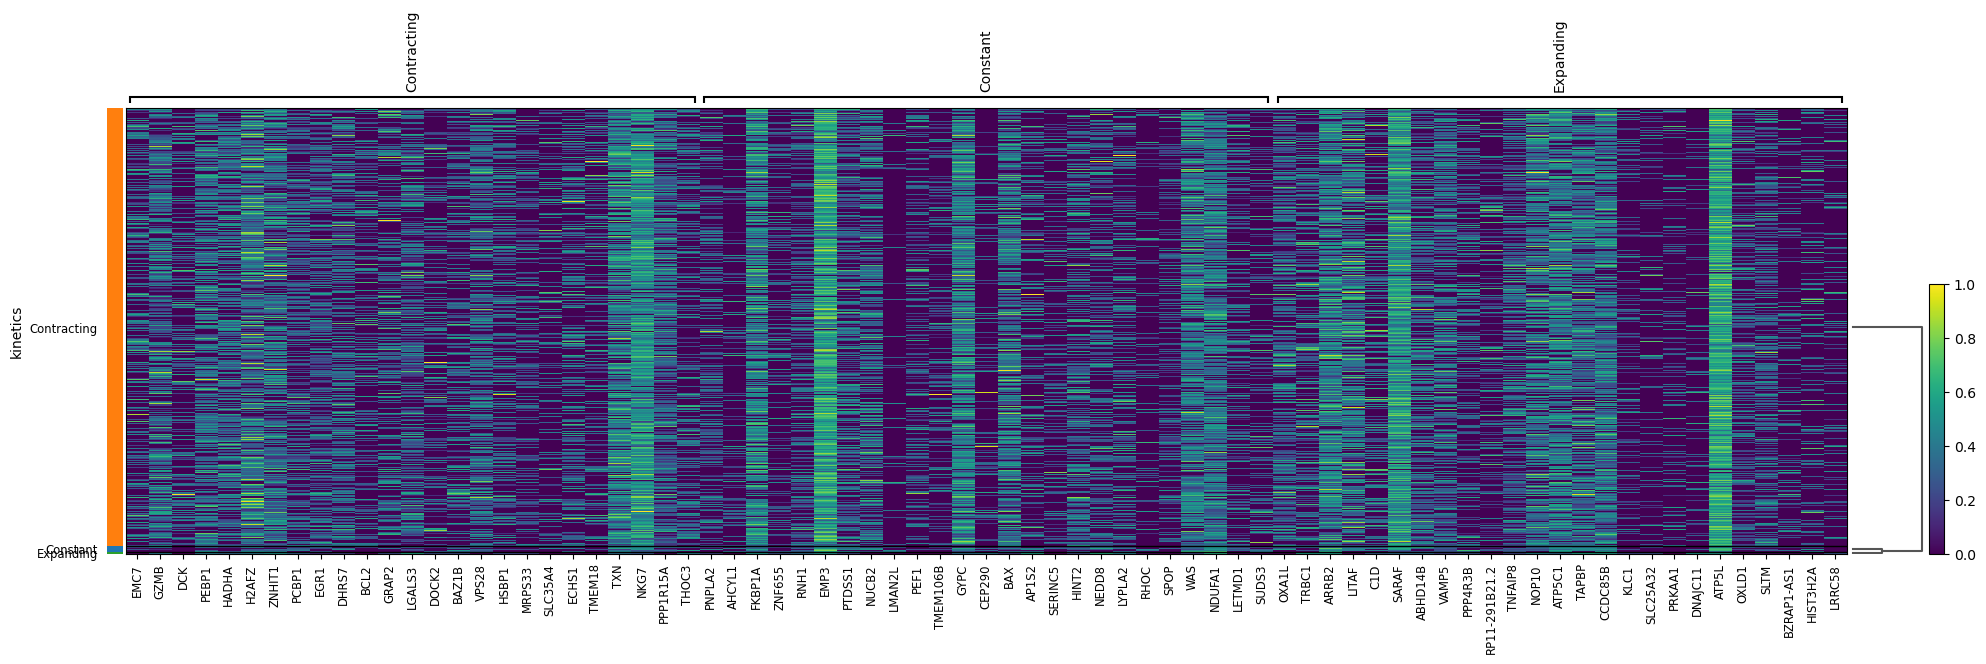

NHL-6


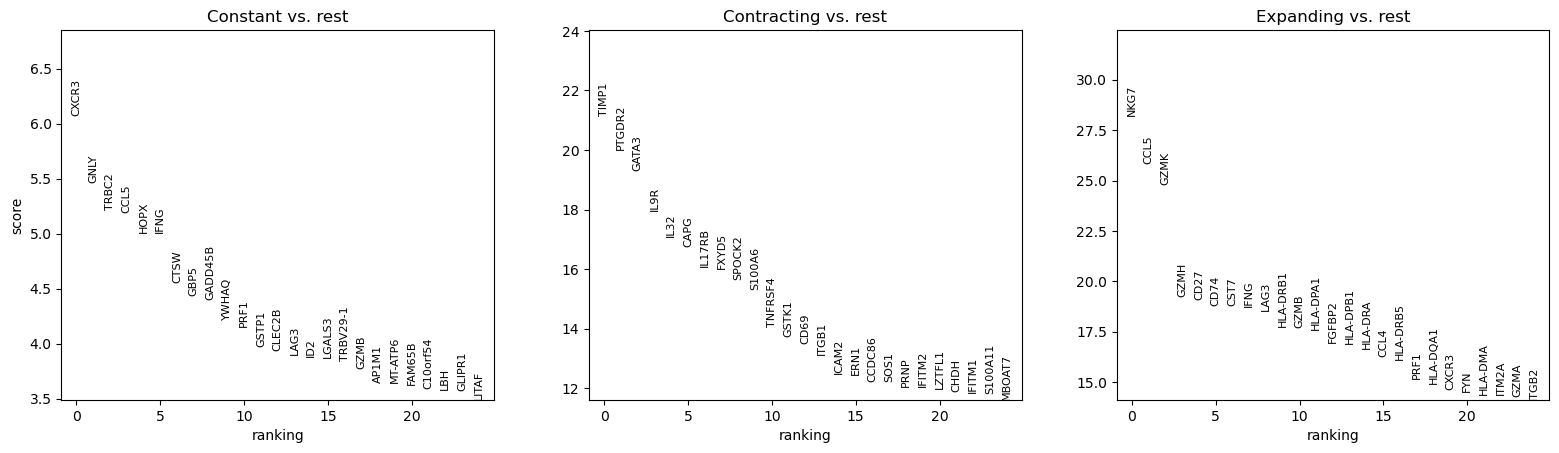

         Falling back to preprocessing with `sc.pp.pca` and default params.


/Users/elanasimon/miniconda3/envs/bmi/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


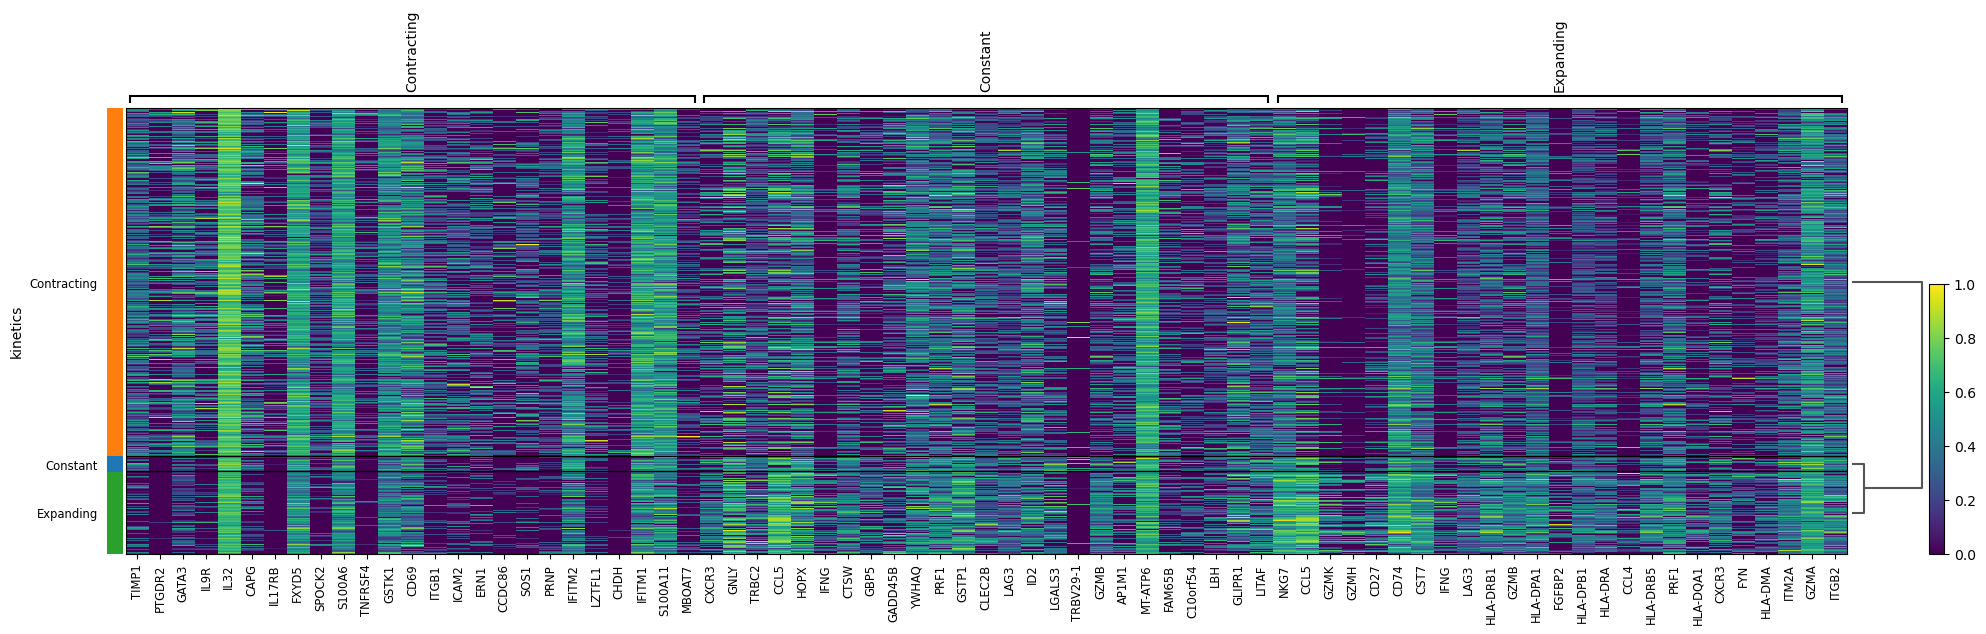

CLL-2


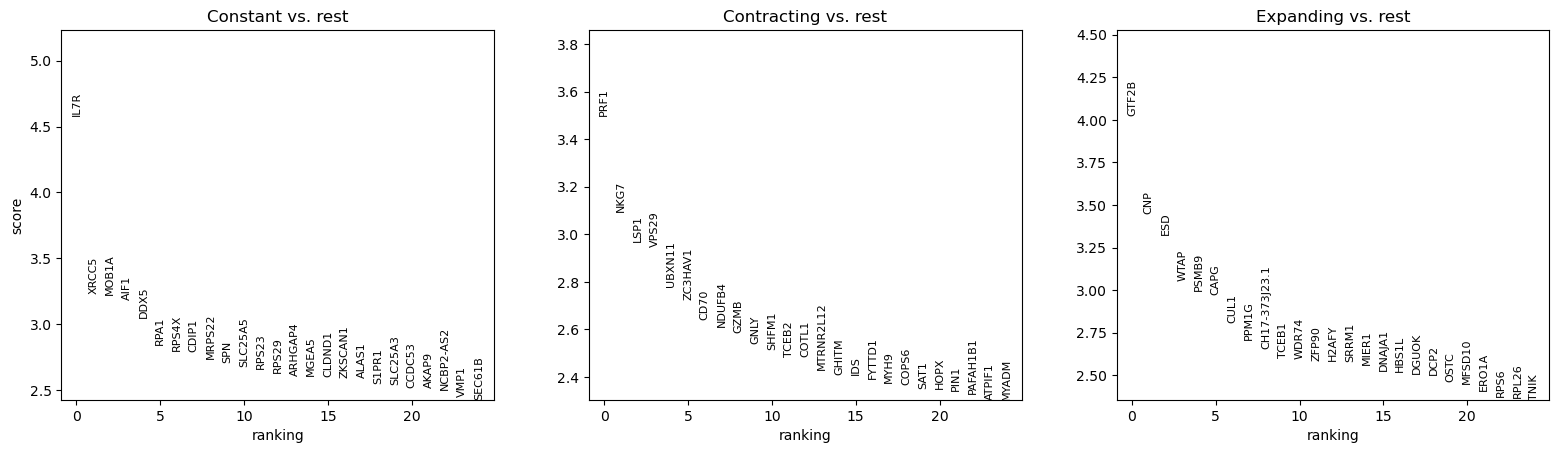

         Falling back to preprocessing with `sc.pp.pca` and default params.


/Users/elanasimon/miniconda3/envs/bmi/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


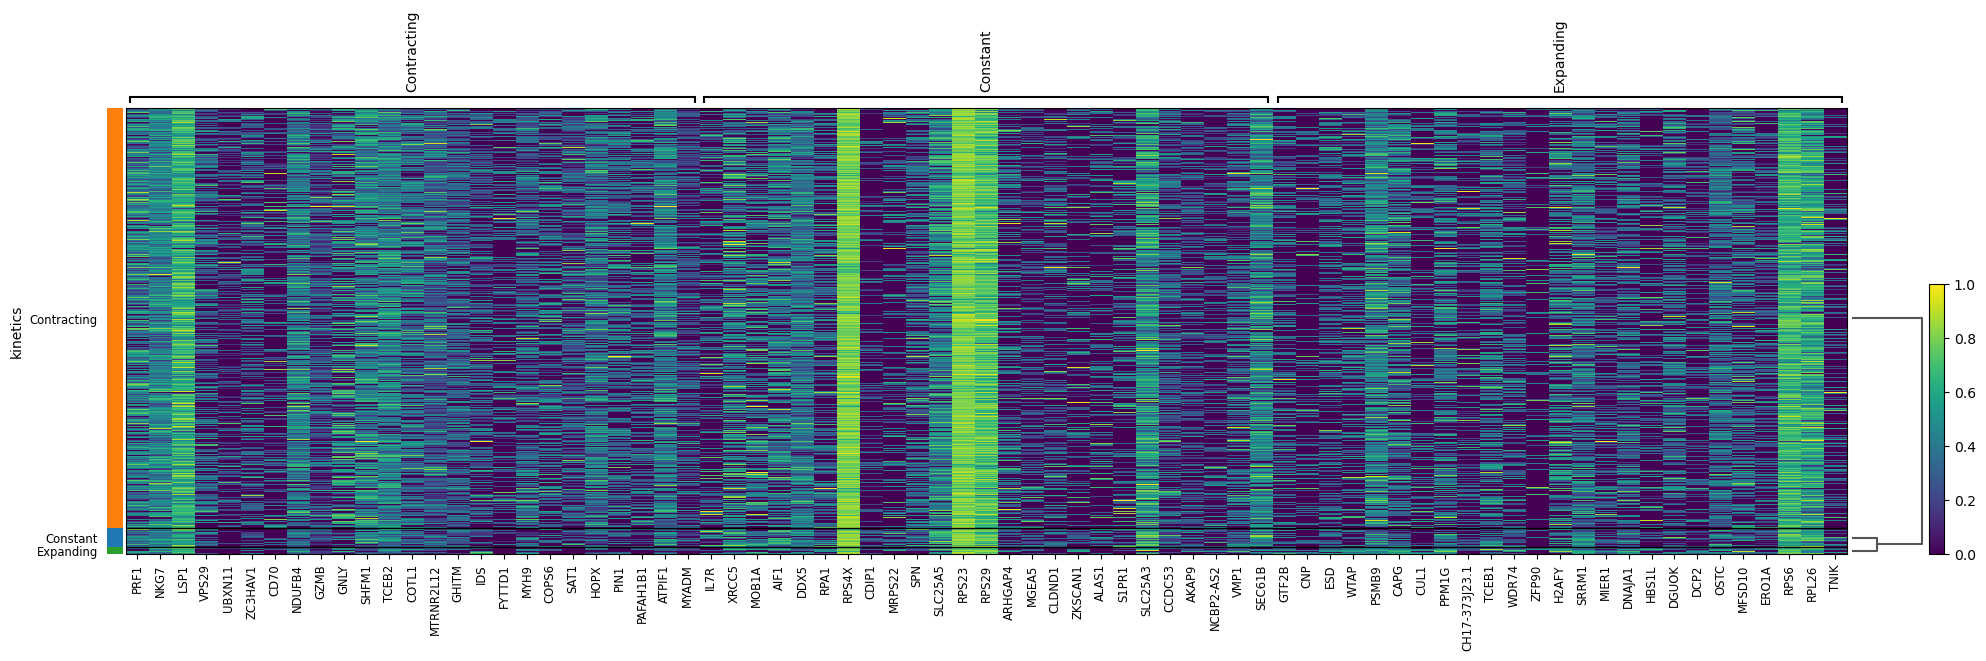

NHL-7


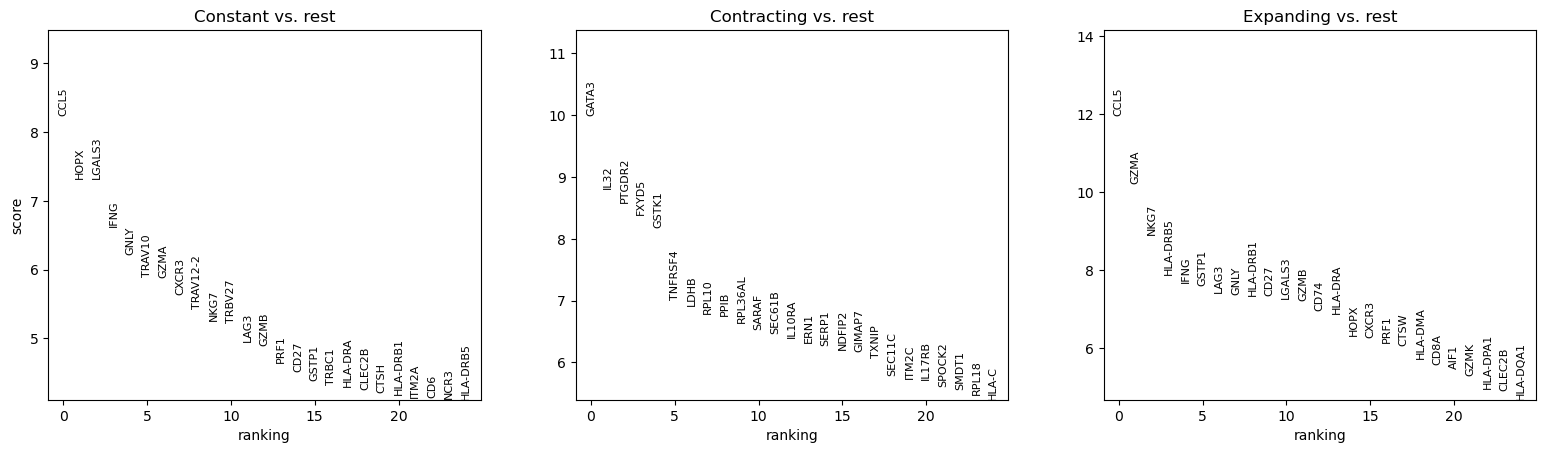

         Falling back to preprocessing with `sc.pp.pca` and default params.


/Users/elanasimon/miniconda3/envs/bmi/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


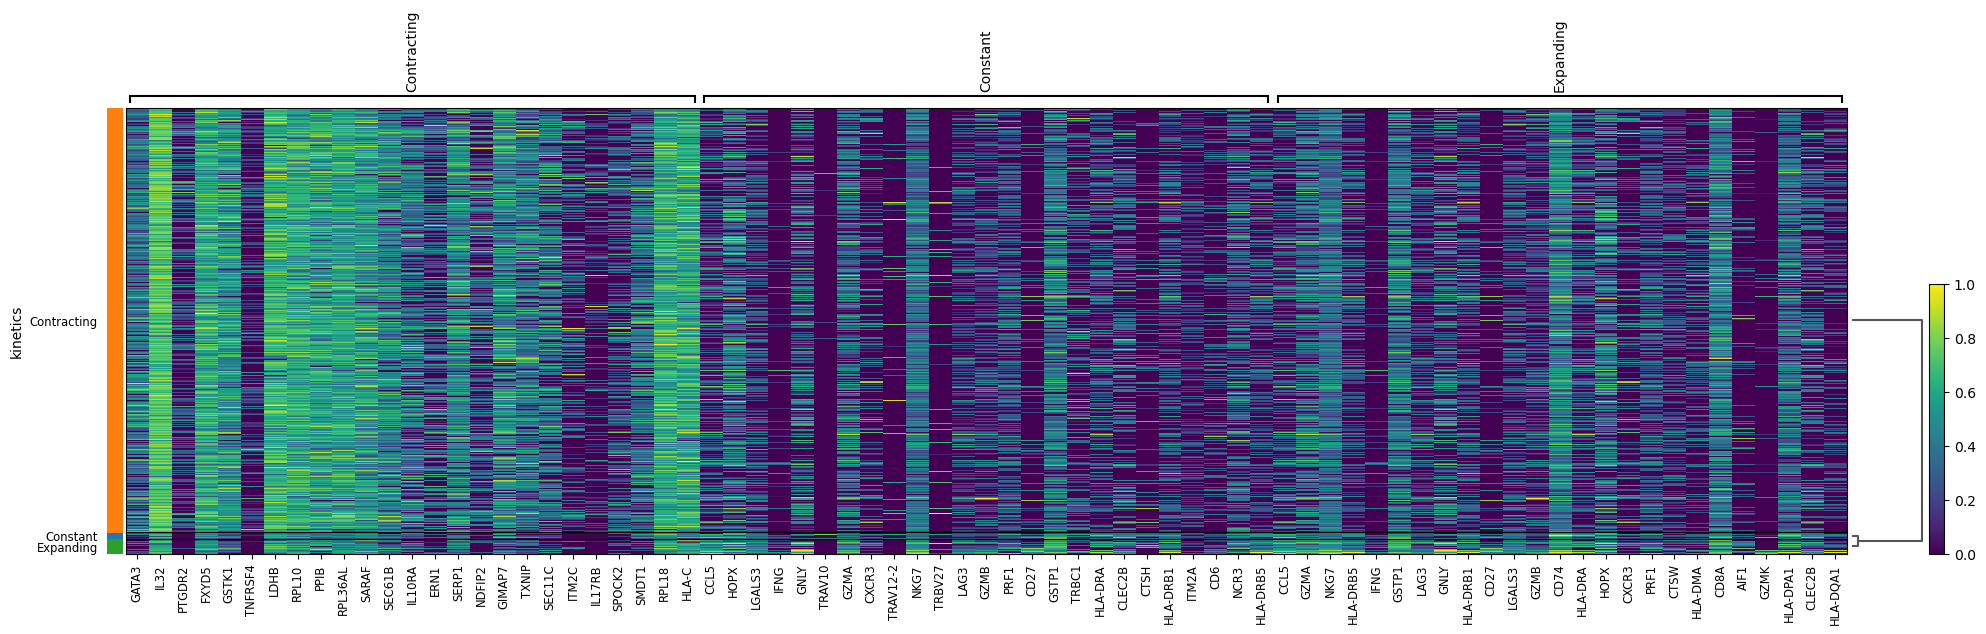

In [76]:
for pat_id in expr.obs["patient_id"].unique():
    print(pat_id)
    plot_deg_for_subset(barcode_kinetics["early"], expr[(expr.obs["time_point_type"]=="IP")&(expr.obs["patient_id"]==pat_id)].copy())

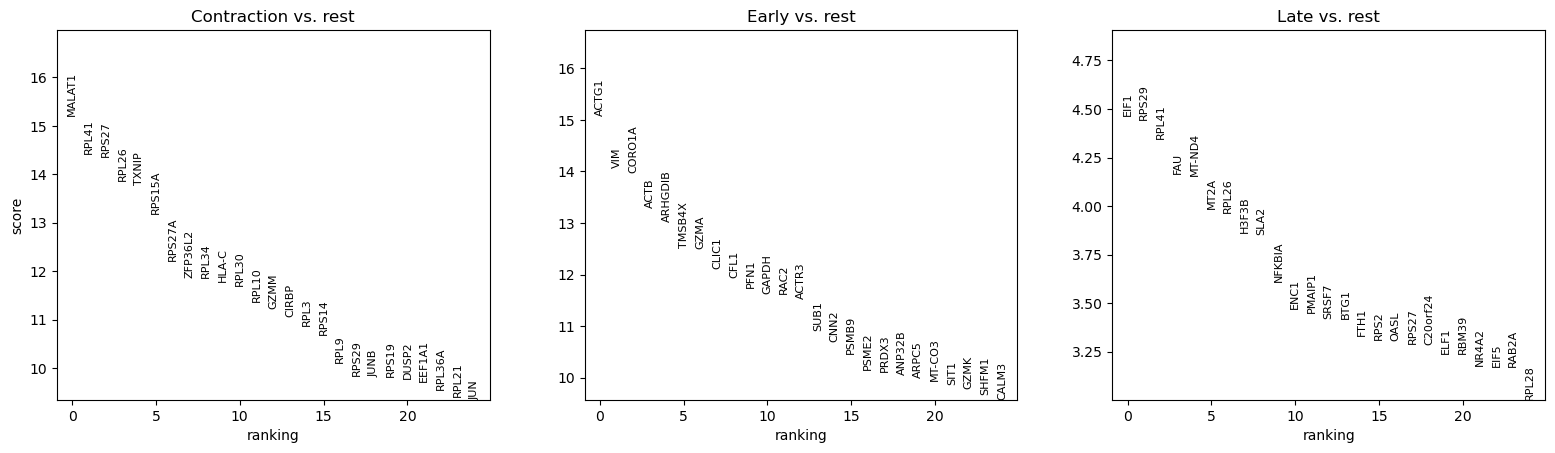

         Falling back to preprocessing with `sc.pp.pca` and default params.


/Users/elanasimon/miniconda3/envs/bmi/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


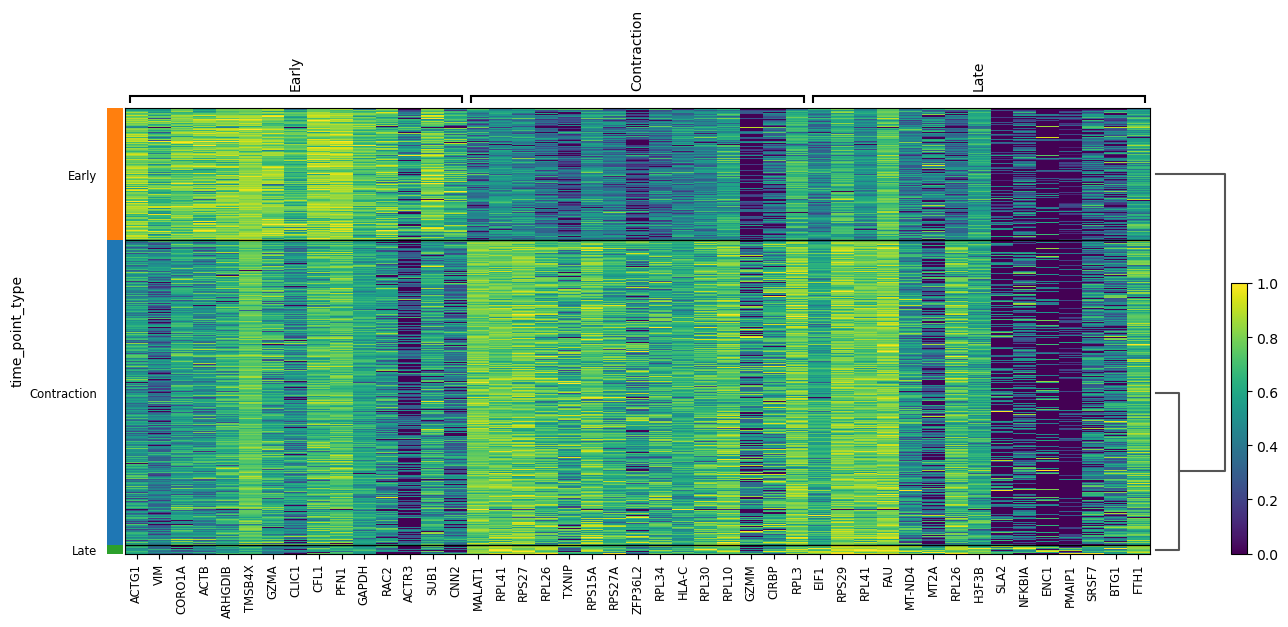

In [95]:
clone_id = "NHL-7-917"
expr_for_clone = expr[expr.obs.clone_id == clone_id].copy()
sc.tl.rank_genes_groups(expr_for_clone, groupby="time_point_type", method="wilcoxon", n_genes=1000)
sc.pl.rank_genes_groups(expr_for_clone, n_genes=25, sharey=False)
sc.pl.rank_genes_groups_heatmap(expr_for_clone, n_genes = 15, key="rank_genes_groups", groupby="time_point_type", show_gene_labels=True, standard_scale="var")

/Users/elanasimon/miniconda3/envs/bmi/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


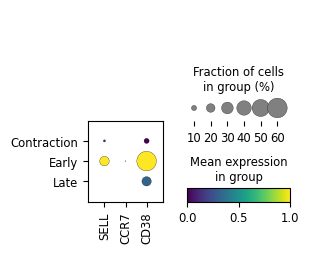

In [101]:
# plot dotplot of expression for clones for specific list of genes "VIM", "HLA-DRB1"
genes_to_plot = ["SELL", "CCR7", "CD38"]
sc.pl.dotplot(expr_for_clone, var_names=genes_to_plot, groupby="time_point_type", use_raw=False, standard_scale="var", color_map="viridis")

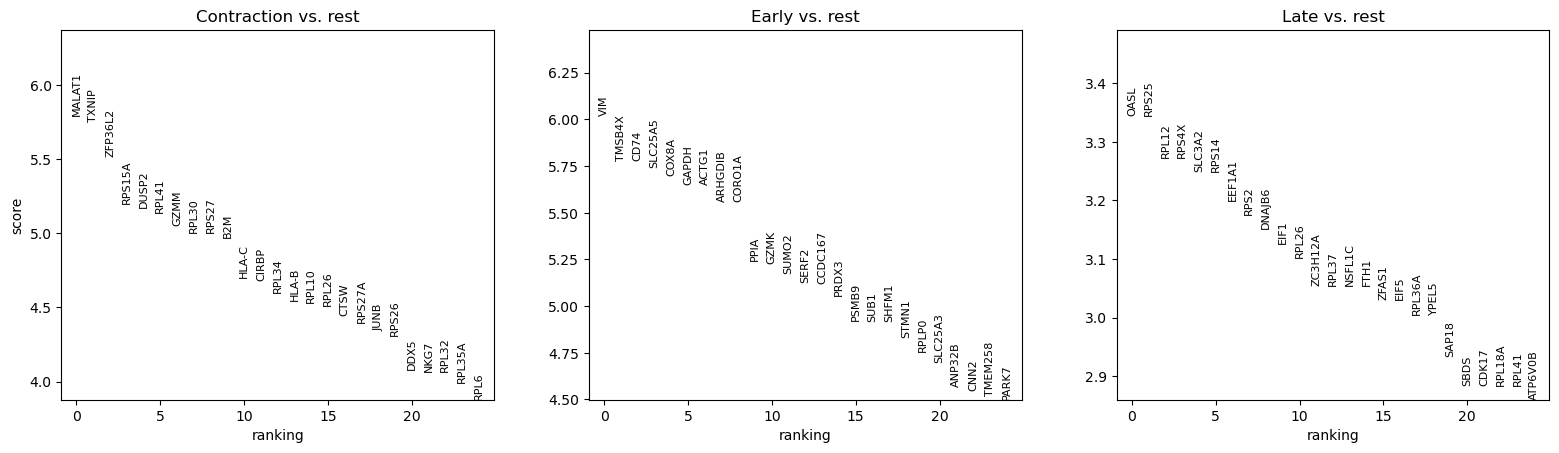

         Falling back to preprocessing with `sc.pp.pca` and default params.


/Users/elanasimon/miniconda3/envs/bmi/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


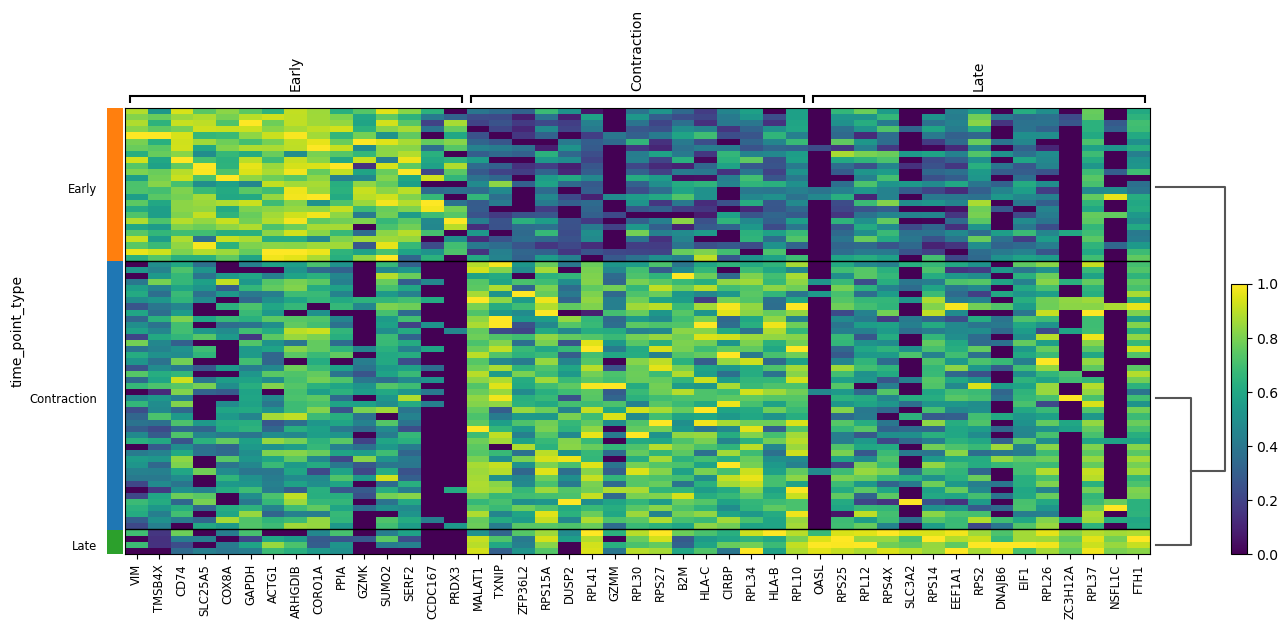

In [94]:
clone_id = "NHL-7-923"
expr_for_clone = expr[expr.obs.clone_id == clone_id].copy()
sc.tl.rank_genes_groups(expr_for_clone, groupby="time_point_type", method="wilcoxon", n_genes=1000)
sc.pl.rank_genes_groups(expr_for_clone, n_genes=25, sharey=False)
sc.pl.rank_genes_groups_heatmap(expr_for_clone, n_genes = 15, key="rank_genes_groups", groupby="time_point_type", show_gene_labels=True, standard_scale="var")

In [103]:
expr_for_clone.obs

,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,n_genes,has_tcr_data,sample_id,disease_state,time_point_type,patient_id,clone_id
AAAGATGCACAGCCCA-13,1372,3725.0,290.0,7.785234,1372,True,13,NHL,Early,NHL-7,NHL-7-917
AAAGCAACAAGGACTG-13,1025,2185.0,168.0,7.688787,1025,True,13,NHL,Early,NHL-7,NHL-7-917
AAAGTAGCACTTACGA-13,2742,8778.0,579.0,6.596035,2742,True,13,NHL,Early,NHL-7,NHL-7-917
AAAGTAGGTAGATTAG-13,2135,5896.0,383.0,6.495930,2135,True,13,NHL,Early,NHL-7,NHL-7-917
AACGTTGTCCTGTACC-13,1894,6047.0,330.0,5.457252,1894,True,13,NHL,Early,NHL-7,NHL-7-917
...,...,...,...,...,...,...,...,...,...,...,...
ATCATGGTCCTTTCTC-15,1210,3306.0,145.0,4.385965,1210,True,15,NHL,Late,NHL-7,NHL-7-917
CACTCCAGTCACACGC-15,1363,3933.0,227.0,5.771676,1363,True,15,NHL,Late,NHL-7,NHL-7-917
GACAGAGTCCACGCAG-15,1130,3243.0,274.0,8.448967,1130,True,15,NHL,Late,NHL-7,NHL-7-917
TGCTGCTAGGCAATTA-15,1401,3642.0,175.0,4.805052,1401,True,15,NHL,Late,NHL-7,NHL-7-917
